# Preprocessing: Bitcoin/USD (Hourly)
This notebook processes Bitcoin price data from Kaggle.
**Source:** Kaggle BTC/USD (Minute Raw)
**Target:** Hourly frequency (Resampled), `timestamp` index, `btc_usd` column.

**Steps:**
1. Load raw data.
2. Transform to time series format.
3. Data cleaning (Null check, Data types).
4. Set Index and Frequency.
5. Save processed dataset.
6. Visualization check.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

# Configuration
input_file = '../datasets/kaggle_btcusd_minute_raw.csv'
output_file = '../datasets/kaggle_btcusd_hourly.csv'

# Ensure output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

In [37]:
# 1. Load Data
try:
    df_raw = pd.read_csv(input_file)
    print("Raw data loaded successfully.")
    print(df_raw.head())
    print(df_raw.columns)
except Exception as e:
    print(f"Error loading data: {e}")

Raw data loaded successfully.
      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0
Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [38]:
# 2. Transform to Time Series Format
# Identify timestamp and close columns
# We need to inspect the columns first, but let's write generic code that we can adjust if needed.

# Identify Datetime Column
if 'Timestamp' in df_raw.columns:
    # Check if it's unix timestamp (large integers)
    if df_raw['Timestamp'].dtype == 'int64' or df_raw['Timestamp'].dtype == 'float64':
        df_raw['datetime'] = pd.to_datetime(df_raw['Timestamp'], unit='s')
    else:
        df_raw['datetime'] = pd.to_datetime(df_raw['Timestamp'])
elif 'Date' in df_raw.columns:
    df_raw['datetime'] = pd.to_datetime(df_raw['Date'])
else:
    # Fallback: try to find a column with 'date' or 'time' in name
    date_cols = [c for c in df_raw.columns if 'date' in c.lower() or 'time' in c.lower()]
    if date_cols:
        df_raw['datetime'] = pd.to_datetime(df_raw[date_cols[0]])
    else:
        raise ValueError("Could not identify datetime column")

# Identify Close Price Column
close_col = [c for c in df_raw.columns if 'close' in c.lower()]
if close_col:
    close_col = close_col[0]
else:
    raise ValueError("Could not identify Close column")

print(f"Using datetime column: datetime (derived)")
print(f"Using close column: {close_col}")

# Set Index
df_raw.set_index('datetime', inplace=True)
df_raw.sort_index(inplace=True)

# Resample to Hourly
# We take the 'last' value of the hour for the Close price
df_hourly = df_raw[close_col].resample('h').last()

# Rename to standard
df = df_hourly.to_frame(name='btc_usd')

print("First 5 rows after transformation:")
print(df.head())

Using datetime column: datetime (derived)
Using close column: Close
First 5 rows after transformation:
                     btc_usd
datetime                    
2012-01-01 10:00:00     4.58
2012-01-01 11:00:00     4.58
2012-01-01 12:00:00     4.58
2012-01-01 13:00:00     4.58
2012-01-01 14:00:00     4.58


In [39]:
# 3. Data Cleaning
# Check for missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# For Bitcoin price, forward fill is often better than dropping if gaps are small, 
# but if we have large gaps, we might want to drop. 
# Here we will use forward fill to maintain continuity, then drop any remaining leading NaNs.
df.ffill(inplace=True)
df.dropna(inplace=True)

print("\nMissing values after cleaning:")
print(df.isnull().sum())

# Check Data Types
print("\nData Types:")
print(df.dtypes)

Missing values before cleaning:
btc_usd    18
dtype: int64

Missing values after cleaning:
btc_usd    0
dtype: int64

Data Types:
btc_usd    float64
dtype: object


In [40]:
# 4. Set Index and Frequency
# Set frequency to Hourly ('h')
# asfreq() enforces the frequency. If there were missing rows, it would reintroduce NaNs (which we handled above).
df = df.asfreq('h')

print("Index Frequency:", df.index.freq)
print(df.index)

Index Frequency: <Hour>
DatetimeIndex(['2012-01-01 10:00:00', '2012-01-01 11:00:00',
               '2012-01-01 12:00:00', '2012-01-01 13:00:00',
               '2012-01-01 14:00:00', '2012-01-01 15:00:00',
               '2012-01-01 16:00:00', '2012-01-01 17:00:00',
               '2012-01-01 18:00:00', '2012-01-01 19:00:00',
               ...
               '2025-12-21 14:00:00', '2025-12-21 15:00:00',
               '2025-12-21 16:00:00', '2025-12-21 17:00:00',
               '2025-12-21 18:00:00', '2025-12-21 19:00:00',
               '2025-12-21 20:00:00', '2025-12-21 21:00:00',
               '2025-12-21 22:00:00', '2025-12-21 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=122486, freq='h')


In [41]:
# 5. Save Processed Data
df.to_csv(output_file)
print(f"Processed data saved to: {output_file}")

Processed data saved to: ../datasets/kaggle_btcusd_hourly.csv


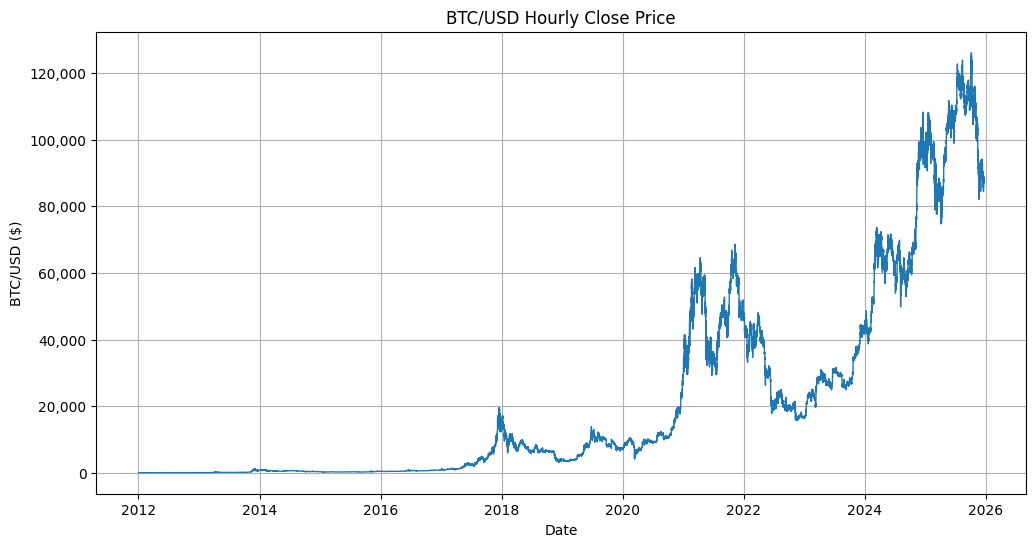

In [42]:
# 6. Visualization Check
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['btc_usd'], linestyle='-', linewidth=1)
plt.title('BTC/USD Hourly Close Price')
plt.xlabel('Date')
plt.ylabel('BTC/USD ($)')
plt.grid(True)

# Format y-axis with comma separator
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()